In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib import pyplot
import numpy as np
from skimage.metrics import structural_similarity as ssim
from sklearn.metrics import mean_squared_error
import math

In [3]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim

    new_shape = tf.cast(shape * scale, tf.int32)

    img = tf.image.resize(img, new_shape)
    # in order to use CNN, add one additional dimension
    # to the original image
    # img shape: [height, width, channel] -> [batch_size, height, width, channel]
    img = img[tf.newaxis, :]

    return img

In [4]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

Image shape: (1, 512, 320, 3)


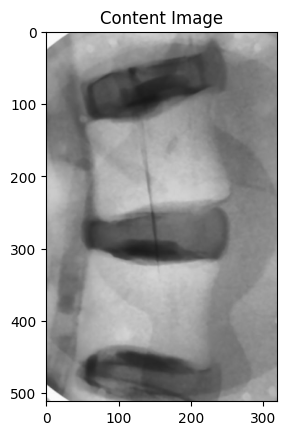

In [46]:
content_path = '/content/drive/MyDrive/forgdrive/testSET55LP.jpg'
op_path = '/content/drive/MyDrive/forgdrive/IntermodelLP/ResNet50_LPop.png'
content_image = load_img(content_path)
op_image = load_img(op_path)
print('Image shape:', content_image.shape)
imshow(content_image, 'Content Image')

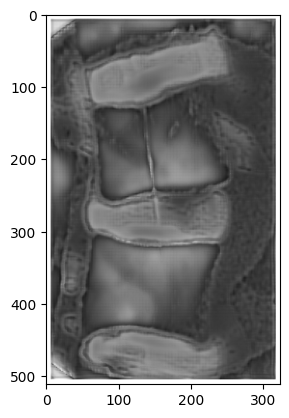

In [47]:
imshow(op_image)

In [48]:
x = tf.keras.applications.vgg19.preprocess_input(content_image*255)
x = tf.image.resize(x, (310,310))

x1 = tf.keras.applications.vgg19.preprocess_input(op_image*255)
x1 = tf.image.resize(x1, (310,310))
# load pretrained network(VGG19)
vgg = tf.keras.applications.VGG19(include_top=True, weights='imagenet')
"""
prediction_probabilities = vgg(x)
prediction_probabilities.shape
"""

'\nprediction_probabilities = vgg(x)\nprediction_probabilities.shape\n'

In [49]:
plt.figure(figsize=(16,16))

# redefine model to output right after the first hidden layer
model = tf.keras.Model(inputs=[vgg.input], outputs=vgg.layers[15].output)
model.summary()

# preprocess input
content_image = tf.keras.applications.vgg19.preprocess_input(content_image*255)
content_image = tf.image.resize(content_image, (224,224))
#content_image.shape # output: TensorShape([1, 224, 224, 3])
op_image = tf.keras.applications.vgg19.preprocess_input(op_image*255)
op_image = tf.image.resize(op_image, (224,224))


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

<Figure size 1600x1600 with 0 Axes>

1/1 [==============================] - 1s 1s/step
<class 'numpy.ndarray'>


(28, 28, 512)

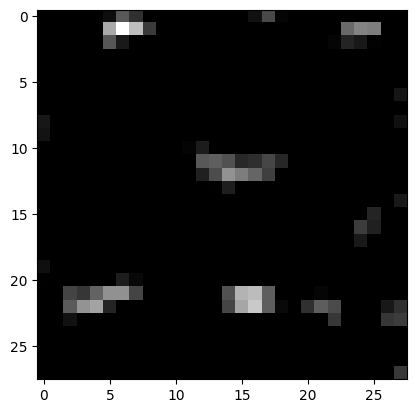

In [50]:
# get feature map for first hidden layer
feature_cmaps = model.predict(content_image)
print(type(feature_cmaps)) #type is numpy.ndarray
# plot all 64 maps in an 8x8 squares
content_maps = np.zeros((28,28,512))
square = 8
ix = 1
'''
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
'''
for i in range(feature_cmaps.shape[3]):
  pyplot.imshow(feature_cmaps[0, :, :, ix-1], cmap='gray')
  content_maps[:, :, ix - 1] = feature_cmaps[0, :, :, ix - 1]
  ix += 1

# show the figure
#pyplot.show()
content_maps.shape
#print(feature_cmaps)

1/1 [==============================] - 1s 549ms/step
<class 'numpy.ndarray'>


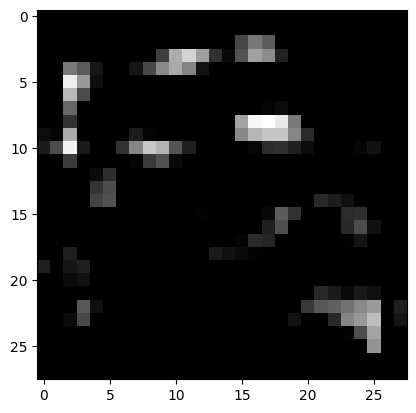

(1, 28, 28, 512)

In [51]:
# get feature map for first hidden layer
feature_smaps = model.predict(op_image)
print(type(feature_smaps)) #type is numpy.ndarray
# plot all 64 maps in an 8x8 squares

op_maps = np.zeros((28,28,512))
square = 8
ix = 1
'''
for _ in range(square):
    for _ in range(square):
        # specify subplot and turn of axis
        ax = pyplot.subplot(square, square, ix)
        ax.set_xticks([])
        ax.set_yticks([])
        # plot filter channel in grayscale
'''
for i in range(feature_smaps.shape[3]):
  pyplot.imshow(feature_smaps[0, :, :, ix-1], cmap='gray')
  op_maps[ :, :, ix - 1]=feature_smaps[0, :, :, ix - 1]
  ix += 1
# show the figure
pyplot.show()
feature_smaps.shape
#print(feature_smaps)

In [52]:
print(feature_cmaps.shape[1]*feature_cmaps.shape[2])

784


In [53]:
initial_content_nans = np.isnan(content_maps).sum()
initial_op_nans = np.isnan(op_maps).sum()

print("Initial number of NaNs in content_maps:", initial_content_nans)
print("Initial number of NaNs in op_maps:", initial_op_nans)

Initial number of NaNs in content_maps: 0
Initial number of NaNs in op_maps: 0


In [54]:
epsilon = 1e-11
def normalize_feature_maps(feature_maps, name=""):
    normalized_maps = np.zeros_like(feature_maps)
    for i in range(feature_maps.shape[-1]):
        fmap = feature_maps[:, :, i]
        mean = np.mean(fmap)
        std = np.std(fmap)
        if std < epsilon:
            std = epsilon  # Avoid division by zero
        normalized_maps[:, :, i] = (fmap - mean) / std
    return normalized_maps

In [55]:
content_maps = normalize_feature_maps(content_maps, name="content_maps")
op_maps = normalize_feature_maps(op_maps, name="op_maps")

In [56]:
print("Number of NaNs in content_maps:", np.isnan(content_maps).sum())
print("Number of NaNs in op_maps:", np.isnan(op_maps).sum())

Number of NaNs in content_maps: 0
Number of NaNs in op_maps: 0


In [57]:
print("Range of content_maps:", np.min(content_maps), np.max(content_maps))
print("Range of op_maps:", np.min(op_maps), np.max(op_maps))

Range of content_maps: -0.6538900733418698 27.982137159266447
Range of op_maps: -0.5631565868249524 27.982137159266447


In [58]:
sad_values = []

for i in range(feature_cmaps.shape[3]):
  #fmap1 = content_maps[:, :, i]
  #fmap2 = op_maps[:, :, i]
  denominator = feature_cmaps.shape[1]*feature_cmaps.shape[2]
  sad = np.sum(np.abs(op_maps[:, :, i] - content_maps[:, :, i]))/denominator
  sad_values.append(sad)
  #ssim_value, _ = ssim(fmap1, fmap2, full=True)
  #ssim_values.append(ssim_value)
  #print(fmap1.shape)

print(sad_values)
mean_sad = np.mean(sad_values)
print(mean_sad)


[0.4844677146454603, 0.4524726389977594, 0.43782493054515875, 0.6675490625992027, 0.6664595820195511, 0.4015757387986793, 0.34801451777097253, 0.6829977238281512, 0.24134338293733815, 0.4009873140835344, 0.38893780789296845, 0.3660771371686074, 0.3310827235519399, 0.6137812883289138, 0.4647599152753884, 0.3627406804734339, 0.4617186891833903, 0.5369172168332176, 0.33990241714168884, 0.18339401090500249, 0.5104103016244458, 0.38895834846733257, 0.44220028168642256, 0.4053540621744153, 0.3409218929746601, 0.5828984883128753, 0.5590952921738964, 0.5670639247771595, 0.5384704252307735, 0.5258890525893829, 0.6055796355876152, 0.42377995462898016, 0.5970205424595351, 0.4062468363073951, 0.5139878202243224, 0.4222529581802061, 0.30902628362562035, 0.5621487588928195, 0.482727829423403, 0.5356984484798553, 0.44194497971713365, 0.2672177729206918, 0.408406420469981, 0.3877294397079596, 0.329259239188133, 0.4996641465559175, 0.3409646484534541, 0.4426904674952576, 0.576207363972931, 0.5770192012

In [ ]:
sad_values = np.array(sad_values)
print("SSIM values range:", sad_values.min(), "to", sad_values.max())


SSIM values range: 0.13155756657300618 to 0.7208413795694392


In [ ]:
filtered_sad_values = sad_values[(sad_values >= -1) & (sad_values <= 1)]
mean_sad = np.mean(filtered_sad_values)
print(f"Mean SAD: {mean_sad}")
out_of_range_values = sad_values[(sad_values < -1) | (sad_values > 1)]
print(f"Out of range SAD values: {out_of_range_values}")

Mean SAD: 0.29849444965262756
Out of range SAD values: []


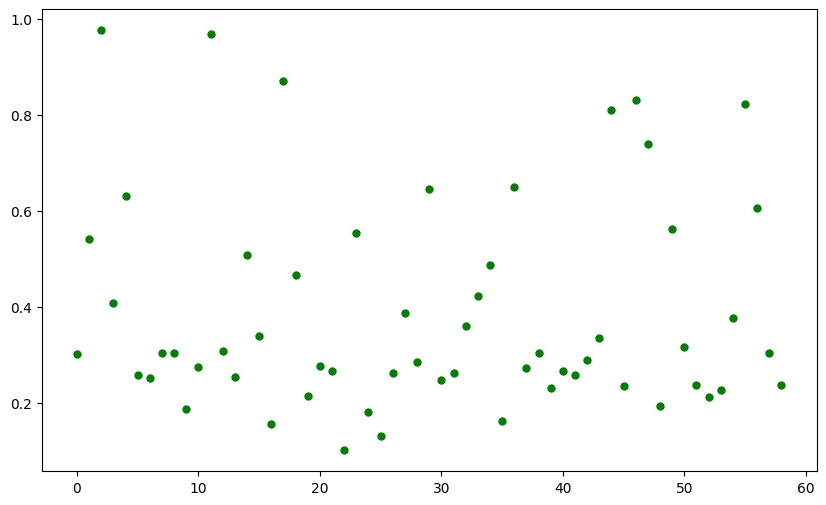

In [ ]:
# Create a plot
plt.figure(figsize=(10, 6))

# Plot SSIM values
plt.plot(filtered_sad_values, marker='o', linestyle='', color='g', markersize=5)
#plt.plot(ssim_values, marker='o', linestyle='', color='r', markersize=5)

ValueError: The number of FixedLocator locations (4), usually from a call to set_ticks, does not match the number of labels (3).

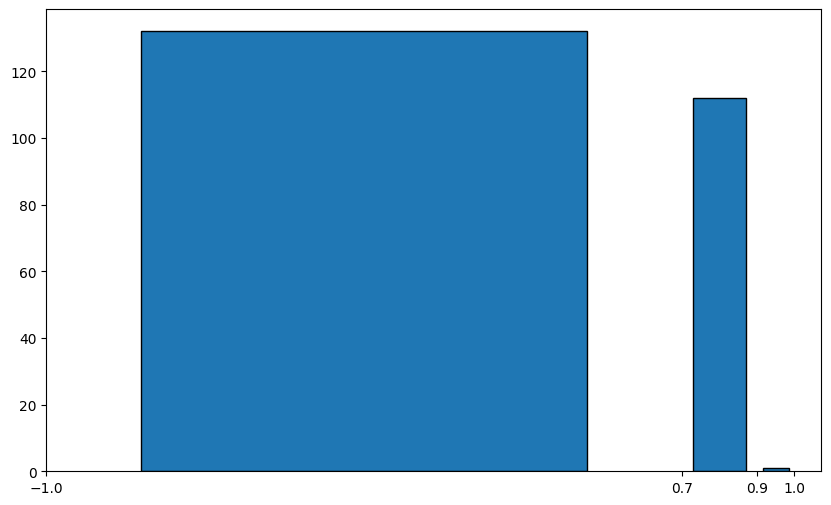

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define bins for SSIM ranges
bins = [-1, 0.7, 0.9, 1]
bin_labels = ['< 0.7', '0.7 - 0.9', '> 0.9']

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(filtered_ssim_values, bins=bins, edgecolor='black', rwidth=0.7, align='mid')

# Set the tick labels to be the bin labels
plt.xticks(bins, ['< 0.7', '0.7 - 0.9', '> 0.9'])
plt.xlabel('SSIM Value Range')
plt.ylabel('Frequency')
plt.title('Histogram of SSIM Values')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import itertools

0.2929809660845397


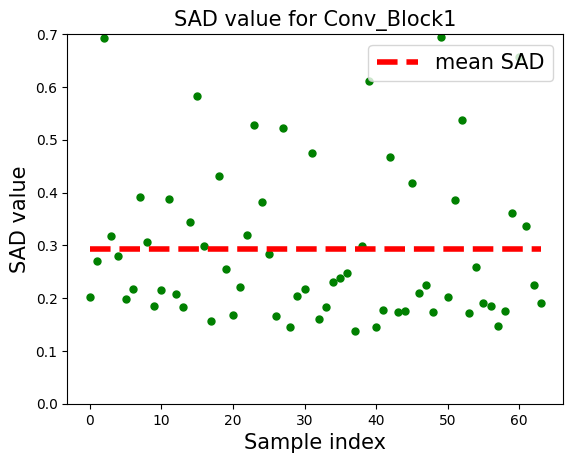

In [ ]:
a = [0.2022858768972758, 0.2695446197144159, 0.6928450738967076, 0.3185814484201849, 0.28033401067693714, 0.19858178128714346, 0.2172500242830649, 0.39147536568377245, 0.3070707561347118, 0.1859695686017107, 0.21499963572704017, 0.38857137935958364, 0.20812774890569838, 0.1841178692079996, 0.3434937931355702, 0.5830316841293947, 0.29850740708088086, 0.15613223377165236, 0.43102885729542023, 0.2554713657717114, 0.1681854238682478, 0.22064718179268683, 0.3198761541731965, 0.5276051752435941, 0.3819358373872604, 0.2833675986738827, 0.16579035616888485, 0.5223484520132238, 0.14455171159569333, 0.2033725182531954, 0.21735244809708792, 0.4742854372549473, 0.15982832634225544, 0.18380789244390067, 0.23075105365411502, 0.2384216298994088, 0.24756943407920637, 0.1375379669171442, 0.2991765748099401, 0.6107355406023053, 0.1459469502004674, 0.17809244347937325, 0.46733683917294533, 0.17340872322613726, 0.1751069103058555, 0.41770105123453644, 0.20887959050399443, 0.22539477893326407, 0.17399035634653606, 0.6945405371969268, 0.20153408334900802, 0.38559124714025633, 0.5370911633050114, 0.17176409592180275, 0.2587739870833288, 0.19000919902252564, 0.18532625662965654, 0.14699366315495177, 0.1760773259575762, 0.36202656560056234, 0.6567323403446829, 0.3369057267783243, 0.22534879670409383, 0.19164198456767187]
a1 = np.array(a)
mean = np.mean(a1)
print(mean)
plt.plot(a, marker='o', linestyle='', color='g', markersize=5)
x = list(itertools.islice(itertools.count(0),64))
y = [mean] * 64
plt.plot(x, y, linestyle='--', color='r', lw = '4', label = 'mean SAD' )  # Plot the chart
plt.ylim([0, 0.7])
plt.xlabel('Sample index', fontsize=15)
plt.ylabel('SAD value', fontsize=15)
plt.title('SAD value for Conv_Block1', fontsize=15)
plt.legend(loc='upper right', fontsize=15)
plt.show()